<a href="https://colab.research.google.com/github/fffairforce/BME547/blob/master/BME_MML_Lecture_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip3 install tensorflow_datasets
!pip3 install tensorflow-gpu==2.0.0-rc0

In [0]:
!nvidia-smi

In [0]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

In [0]:
test = tfds.Split.TRAIN.subsplit(tfds.percent[-25:])
train = tfds.Split.TRAIN.subsplit(tfds.percent[:75])
training_ds = tfds.load('titanic', split=train)
test_ds = tfds.load()

In [0]:
# Get Data
BATCH_SIZE = 100
TOTAL_SIZE = 1309
test = tfds.Split.TRAIN.subsplit(tfds.percent[-25:])
train = tfds.Split.TRAIN.subsplit(tfds.percent[:75])
train_ds = tfds.load('titanic', split=train)
test_ds = tfds.load('titanic', split=test)
train_ds = train_ds.map(lambda ele: tuple((ele['features'], ele['survived']))).batch(BATCH_SIZE).repeat()
test_ds = test_ds.map(lambda ele: tuple((ele['features'], ele['survived']))).batch(BATCH_SIZE).repeat()

In [0]:
def preview_data(feature_column):
  feature_layer = tf.keras.layers.DenseFeatures(feature_column)
  return feature_layer(feature_batch).numpy()

for feature_batch, label_batch in train_ds.take(1):
  print('Every feature:', list(feature_batch.keys()))

Every feature: ['age', 'boat', 'body', 'cabin', 'embarked', 'fare', 'home.dest', 'name', 'parch', 'pclass', 'sex', 'sibsp', 'ticket']


In [0]:
age = tf.feature_column.numeric_column('age')

pclass = tf.feature_column.indicator_column(
            tf.feature_column.categorical_column_with_identity('pclass', 3)
         )

sex = tf.feature_column.indicator_column(
          tf.feature_column.categorical_column_with_identity('sex', 2)
      )

sibsp = tf.feature_column.numeric_column('sibsp')
parch = tf.feature_column.numeric_column('parch')
fare = tf.feature_column.numeric_column('fare')
home = tf.feature_column.embedding_column(
          tf.feature_column.categorical_column_with_hash_bucket('home.dest', 50), 
       5)

feature_columns = [age, pclass, sex, sibsp, parch, fare, home]

In [0]:
model = tf.keras.Sequential([
  tf.keras.layers.DenseFeatures(feature_columns),
  tf.keras.layers.Dense(1, activation='sigmoid'),
])
model.compile('adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC()])
model.fit(train_ds, steps_per_epoch=int(TOTAL_SIZE*0.75), 
          validation_data=test_ds, 
          validation_steps=int(TOTAL_SIZE*0.25),
          epochs=10)

Train for 981 steps, validate for 327 steps
Epoch 1/10
981/981 [==============================] - 34s 35ms/step - loss: 2.3542 - auc_1: 0.5746 - val_loss: 0.5125 - val_auc_1: 0.8282
Epoch 2/10
981/981 [==============================] - 31s 32ms/step - loss: 0.4910 - auc_1: 0.8220 - val_loss: 0.4737 - val_auc_1: 0.8603
Epoch 3/10
981/981 [==============================] - 32s 32ms/step - loss: 0.4622 - auc_1: 0.8371 - val_loss: 0.4819 - val_auc_1: 0.8533
Epoch 4/10
981/981 [==============================] - 31s 32ms/step - loss: 0.4576 - auc_1: 0.8386 - val_loss: 0.4884 - val_auc_1: 0.8504
Epoch 5/10
981/981 [==============================] - 32s 32ms/step - loss: 0.4565 - auc_1: 0.8389 - val_loss: 0.4908 - val_auc_1: 0.8485
Epoch 6/10
981/981 [==============================] - 31s 32ms/step - loss: 0.4564 - auc_1: 0.8387 - val_loss: 0.4914 - val_auc_1: 0.8492
Epoch 7/10
981/981 [==============================] - 33s 33ms/step - loss: 0.4562 - auc_1: 0.8391 - val_loss: 0.4913 - val_auc_

In [0]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_features_2 (DenseFeatu multiple                  500       
_________________________________________________________________
dense_2 (Dense)              multiple                  20        
Total params: 520
Trainable params: 520
Non-trainable params: 0
_________________________________________________________________


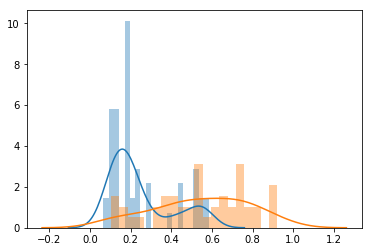

In [0]:
import seaborn as sns
predicted_dead = model.predict(feature_batch)[label_batch==0]
predicted_alive = model.predict(feature_batch)[label_batch==1]
sns.distplot(predicted_dead, bins=20)
sns.distplot(predicted_alive, bins=20)